## import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import time
import random
import os
import uwb_dataset


print("Pytorch Version :", torch.__version__)
%matplotlib inline

Pytorch Version : 1.9.0


## transfer learning

In [2]:
retrain = False
path = os.getcwd()
dir_ = 'model'
checkpoint_name = ''


In [3]:
if retrain:
    checkpoint_path = os.path.join(path, dir_ , checkpoint_name)
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(checkpoint_path)

## Hyper-Parameters

In [4]:
# random seed
random_seed = 42

num_epoch = 100
batch_size = 64
in_channels = 1
num_classes = 2
num_layers = 2
fully_connected = 128

lr = 0.001
weight_decay = 0.0

# Parameters
view_train_iter = 100
view_val_iter = 5
save_point = 0.95

## Random Seed

In [5]:
def torch_random_seed(on_seed=False, random_seed=1):
    if on_seed:
        torch.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        np.random.seed(random_seed)
        random.seed(random_seed)
        
torch_random_seed(on_seed=True, random_seed=random_seed)

## Model Evaluation Function

In [6]:
def get_clf_eval(y_true, y_pred, average='weighted'):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=average, warn_for=tuple())
    return accuracy, precision, recall, f1

## Load UWB data

In [7]:
columns, data = uwb_dataset.import_from_files()

for item in data:
	item[15:] = item[15:]/float(item[2])

print("\nColumns :", columns.shape, sep=" ")
print("Data :", data.shape, sep=" ")

./dataset/uwb_dataset_part1.csv
./dataset/uwb_dataset_part2.csv
./dataset/uwb_dataset_part3.csv
./dataset/uwb_dataset_part4.csv
./dataset/uwb_dataset_part5.csv
./dataset/uwb_dataset_part6.csv
./dataset/uwb_dataset_part7.csv

Columns : (1031,)
Data : (42000, 1031)


## View UWB data

In [8]:
cir_n = len(columns[15:])

print("Columns :", columns, sep=" ")
print("Channel Inpulse Response Count :", cir_n, sep=" ")

Columns : ['NLOS' 'RANGE' 'FP_IDX' ... 'CIR1013' 'CIR1014' 'CIR1015']
Channel Inpulse Response Count : 1016


In [9]:
df_uwb = pd.DataFrame(data=data, columns=columns)
print("Channel 2 count :", df_uwb.query("CH == 2")['CH'].count())
print("Null/NaN Data Count : ", df_uwb.isna().sum().sum())
df_uwb.head(3)

Channel 2 count : 42000
Null/NaN Data Count :  0


,NLOS,RANGE,FP_IDX,FP_AMP1,FP_AMP2,FP_AMP3,STDEV_NOISE,CIR_PWR,MAX_NOISE,RXPACC,...,CIR1006,CIR1007,CIR1008,CIR1009,CIR1010,CIR1011,CIR1012,CIR1013,CIR1014,CIR1015
0,0.0,3.90,745.0,18712.0,10250.0,11576.0,64.0,11855.0,967.0,611.0,...,0.374497,0.614765,0.245638,0.212081,0.265772,0.116779,0.397315,0.677852,0.412081,0.0
1,0.0,0.66,749.0,11239.0,6313.0,4712.0,64.0,18968.0,1133.0,447.0,...,0.192256,0.445928,0.387183,0.304406,0.249666,0.284379,0.269693,0.118825,0.137517,0.0
2,1.0,7.86,746.0,4355.0,5240.0,3478.0,60.0,14699.0,894.0,723.0,...,0.042895,0.500000,0.300268,0.233244,0.166220,0.441019,0.277480,0.128686,0.292225,0.0


In [10]:
los_count = df_uwb.query("NLOS == 0")["NLOS"].count()
nlos_count = df_uwb.query("NLOS == 1")["NLOS"].count()

print("Line of Sight Count :", los_count)
print("Non Line of Sight Count :", nlos_count)

Line of Sight Count : 21000
Non Line of Sight Count : 21000


In [11]:
df_uwb_data = df_uwb[["CIR"+str(i) for i in range(cir_n)]]
print("UWB DataFrame X for Trainndarray shape : ",df_uwb_data.values.shape)
df_uwb_data.head(5)

UWB DataFrame X for Trainndarray shape :  (42000, 1016)


,CIR0,CIR1,CIR2,CIR3,CIR4,CIR5,CIR6,CIR7,CIR8,CIR9,...,CIR1006,CIR1007,CIR1008,CIR1009,CIR1010,CIR1011,CIR1012,CIR1013,CIR1014,CIR1015
0,0.173154,0.418792,0.444295,0.189262,0.214765,0.655034,0.261745,0.193289,0.159732,0.259060,...,0.374497,0.614765,0.245638,0.212081,0.265772,0.116779,0.397315,0.677852,0.412081,0.000000
1,0.156208,0.217623,0.265688,0.181575,0.189586,0.242991,0.477971,0.164219,0.373832,0.415220,...,0.192256,0.445928,0.387183,0.304406,0.249666,0.284379,0.269693,0.118825,0.137517,0.000000
2,0.580429,0.321716,0.312332,0.108579,0.191689,0.678284,0.159517,0.364611,0.332440,0.312332,...,0.042895,0.500000,0.300268,0.233244,0.166220,0.441019,0.277480,0.128686,0.292225,0.000000
3,0.621333,0.329333,0.542667,0.300000,0.372000,0.092000,0.524000,0.581333,0.385333,0.225333,...,0.336000,0.230667,0.264000,0.213333,0.578667,0.529333,0.386667,0.206667,0.456000,0.341333
4,0.347185,0.320375,0.076408,0.025469,0.117962,0.293566,0.536193,0.202413,0.131367,0.556300,...,0.206434,0.280161,0.324397,0.396783,0.116622,0.238606,0.420912,0.331099,0.391421,0.343164


In [12]:
x_train, x_test, y_train, y_test = train_test_split(df_uwb_data.values, df_uwb['NLOS'].values, test_size=0.1, random_state=random_seed, stratify=df_uwb['NLOS'].values)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=random_seed, stratify=y_train)

## Split (Train, Validation, Test) x, label Data

In [13]:
print("x_train shape :", x_train.shape, y_train.shape)
print("x_val shape :", x_val.shape, y_val.shape)
print("x_test shape :", x_test.shape, y_test.shape)

x_train shape : (34020, 1016) (34020,)
x_val shape : (3780, 1016) (3780,)
x_test shape : (4200, 1016) (4200,)


In [14]:
print("Train NLOS 0 count :", len(y_train[y_train==0]))
print("Train NLOS 1 count :", len(y_train[y_train==1]))
print("Validation NLOS 0 count :", len(y_val[y_val==0]))
print("Validation NLOS 1 count :", len(y_val[y_val==1]))
print("Test NLOS 0 count :", len(y_test[y_test==0]))
print("Test NLOS 0 count :", len(y_test[y_test==1]))

Train NLOS 0 count : 17010
Train NLOS 1 count : 17010
Validation NLOS 0 count : 1890
Validation NLOS 1 count : 1890
Test NLOS 0 count : 2100
Test NLOS 0 count : 2100


## Dataset & DataLoader

In [15]:
def generating_loader(x_data, y_data, batch_size=batch_size, shuffle=True, drop_last=True):
    # preprocessing x_data
    x_data = np.expand_dims(x_data, axis=1)
    x_tensor = torch.tensor(x_data, dtype=torch.float32)
    # preprocessing y_data
    y_tensor = torch.tensor(y_data, dtype=torch.long).view(-1)

    return DataLoader(TensorDataset(x_tensor, y_tensor), batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)

In [16]:
trainloader = generating_loader(x_train, y_train, batch_size=batch_size, shuffle=True, drop_last=True)
validationloader = generating_loader(x_val, y_val, batch_size=batch_size, shuffle=False, drop_last=True)
testloader = generating_loader(x_val, y_val, batch_size=batch_size, shuffle=False, drop_last=True)

In [17]:
for x, label in trainloader:
    print(x.shape, label.shape)
    break

torch.Size([64, 1, 1016]) torch.Size([64])


## Create Model 

In [18]:
class CNN_LSTM(nn.Module):
    def __init__(self, in_channels, out_channels, batch_size, num_layers, fully_connected, device):
        super(CNN_LSTM, self).__init__()
        self.batch_size = batch_size
        self.conv1d_layer = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=10, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv1d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
        ) 
        self.lstm = nn.LSTM(input_size = 504, 
                            hidden_size = 32, 
                            num_layers = num_layers,
                            bias = False,
                            dropout = 0.5,
                            bidirectional = True,
                            batch_first=True)

        self.hidden_state, self.cell_state = self.init_hidden()
        
        self.bn = nn.BatchNorm1d(64)
        self.fc_layer = nn.Linear(64, 128)
        self.relu = nn.ReLU()
        self.fc_layer_class = nn.Linear(128, out_channels)


    def init_hidden(self):
        hidden_state = torch.zeros(num_layers*2, self.batch_size, 32).to(device)
        cell_state = torch.zeros(num_layers*2, self.batch_size, 32).to(device)

        return hidden_state, cell_state
        
    def forward(self, x):
        x = self.conv1d_layer(x)
        x, _ = self.lstm(x,(self.hidden_state, self.cell_state))
        x = x[:, -1 :].view(x.size(0), -1)
        x = self.bn(x)
        x = self.fc_layer(x)
        x = self.relu(x)
        x = self.fc_layer_class(x)
        x = self.relu(x)

        return x

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM(
    in_channels=in_channels,\
    device=device,\
    out_channels=num_classes,\
    batch_size=batch_size,\
    fully_connected=fully_connected,\
    num_layers=num_layers).to(device)
loss_function = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # optimizer

In [20]:
start = time.time()

correct = 0
total = 0
train_acc = []
tmp_acc = 0
loss_arr = []

print("*Train Start!!*")
if torch.cuda.device_count() == True:
    print("epoch : {}, learing rate : {}, device : {}".format(num_epoch, lr, torch.cuda.get_device_name(0)))
else:
    print("epoch : {}, learing rate : {}, device : {}".format(num_epoch, lr, device))
print("Model : {}".format(model._get_name()))
print("Loss function : {}".format(loss_function._get_name()))
print("Optimizer : {}".format(str(optimizer).replace("\n", " ").replace("     ", ", ")))
print("*"*100)

correct = 0
total = 0
tmp_acc = 0
train_acc = []
loss_arr = []
val_view_acc = []
start = time.time()  # 시작 시간 저장

for epoch in range(num_epoch):
    epoch = epoch + 1
    for train_iter, (train_x, train_y_true) in enumerate(trainloader):
        model.train()  # Train mode
        model.zero_grad()  # model zero initialize
        optimizer.zero_grad()  # optimizer zero initialize
        
        train_x, train_y_true = train_x.to(device), train_y_true.to(device)  # device(gpu)
        train_y_pred = model.forward(train_x)  # forward

        loss = loss_function(train_y_pred, train_y_true)  # loss function
        loss.backward()  # backward
        optimizer.step()  # optimizer
        _, pred_index = torch.max(train_y_pred, 1)
    
        if train_iter % view_train_iter == 0:
            loss_arr.append(loss.item())
            total += train_y_true.size(0)  # y.size(0)
            correct += (pred_index == train_y_true).sum().float()  # correct
            tmp_acc = correct / total  # accuracy
            train_acc.append(tmp_acc.tolist())
            print("[Train] ({}, {}) loss = {:.5f}, Accuracy = {:.4f}, lr={:.6f}".format(epoch, train_iter, loss.item(), tmp_acc, optimizer.param_groups[0]['lr']))
    # validation 
    if epoch % view_val_iter == 0: 
        val_actual_tmp, val_pred_tmp = [], []
        for val_iter, (val_x, val_y_true) in enumerate(validationloader):
            model.eval()
            val_x, val_y_true = val_x.to(device), val_y_true.to(device)  # device(gpu)
            val_y_pred = model.forward(val_x)  # forward
            _, val_pred_index = torch.max(val_y_pred, 1)
            
            val_pred_index_cpu = val_pred_index.cpu().detach().numpy()
            val_y_true_cpu = val_y_true.cpu().detach().numpy()
            
            val_actual_tmp.append(val_pred_index_cpu.tolist())
            val_pred_tmp.append(val_y_true_cpu.tolist())
            
        val_acc, val_precision, val_recall, val_f1 = get_clf_eval(val_actual_tmp[1], val_pred_tmp[1])
        val_view_acc.append(val_acc)
        print("*[Valid] Accuracy:{:.4f}, Precison:{:.4f}, Recall:{:.4f}, F1 Score:{:.4f}".format(
             val_acc, val_precision, val_recall, val_f1))
print("Time : ", time.time()-start,'[s]',sep='')

*Train Start!!*
epoch : 100, learing rate : 0.001, device : NVIDIA GeForce RTX 2060 SUPER
Model : CNN_LSTM
Loss function : CrossEntropyLoss
Optimizer : Adam ( Parameter Group 0, amsgrad: False, betas: (0.9, 0.999), eps: 1e-08, lr: 0.001, weight_decay: 0.0 )
****************************************************************************************************


C:\Users\Yoon\anaconda3\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


[Train] (1, 0) loss = 0.68704, Accuracy = 0.6875, lr=0.001000
[Train] (1, 100) loss = 0.42302, Accuracy = 0.7422, lr=0.001000
[Train] (1, 200) loss = 0.35409, Accuracy = 0.7969, lr=0.001000
[Train] (1, 300) loss = 0.41555, Accuracy = 0.7930, lr=0.001000
[Train] (1, 400) loss = 0.31510, Accuracy = 0.8125, lr=0.001000
[Train] (1, 500) loss = 0.38404, Accuracy = 0.8073, lr=0.001000
[Train] (2, 0) loss = 0.37173, Accuracy = 0.8147, lr=0.001000
[Train] (2, 100) loss = 0.46200, Accuracy = 0.8125, lr=0.001000
[Train] (2, 200) loss = 0.21119, Accuracy = 0.8229, lr=0.001000
[Train] (2, 300) loss = 0.36068, Accuracy = 0.8234, lr=0.001000
[Train] (2, 400) loss = 0.26921, Accuracy = 0.8324, lr=0.001000
[Train] (2, 500) loss = 0.23369, Accuracy = 0.8385, lr=0.001000
[Train] (3, 0) loss = 0.30426, Accuracy = 0.8425, lr=0.001000
[Train] (3, 100) loss = 0.22138, Accuracy = 0.8482, lr=0.001000
[Train] (3, 200) loss = 0.35889, Accuracy = 0.8458, lr=0.001000
[Train] (3, 300) loss = 0.24684, Accuracy = 0.

[Train] (21, 300) loss = 0.10178, Accuracy = 0.8964, lr=0.001000
[Train] (21, 400) loss = 0.16373, Accuracy = 0.8965, lr=0.001000
[Train] (21, 500) loss = 0.12930, Accuracy = 0.8967, lr=0.001000
[Train] (22, 0) loss = 0.14030, Accuracy = 0.8968, lr=0.001000
[Train] (22, 100) loss = 0.10002, Accuracy = 0.8975, lr=0.001000
[Train] (22, 200) loss = 0.16078, Accuracy = 0.8979, lr=0.001000
[Train] (22, 300) loss = 0.13422, Accuracy = 0.8981, lr=0.001000
[Train] (22, 400) loss = 0.04532, Accuracy = 0.8987, lr=0.001000
[Train] (22, 500) loss = 0.13417, Accuracy = 0.8989, lr=0.001000
[Train] (23, 0) loss = 0.15267, Accuracy = 0.8991, lr=0.001000
[Train] (23, 100) loss = 0.10074, Accuracy = 0.8996, lr=0.001000
[Train] (23, 200) loss = 0.11810, Accuracy = 0.9000, lr=0.001000
[Train] (23, 300) loss = 0.09764, Accuracy = 0.9004, lr=0.001000
[Train] (23, 400) loss = 0.24308, Accuracy = 0.9004, lr=0.001000
[Train] (23, 500) loss = 0.10336, Accuracy = 0.9008, lr=0.001000
[Train] (24, 0) loss = 0.1214

[Train] (42, 100) loss = 0.02597, Accuracy = 0.9372, lr=0.001000
[Train] (42, 200) loss = 0.04623, Accuracy = 0.9374, lr=0.001000
[Train] (42, 300) loss = 0.00569, Accuracy = 0.9377, lr=0.001000
[Train] (42, 400) loss = 0.01400, Accuracy = 0.9379, lr=0.001000
[Train] (42, 500) loss = 0.00251, Accuracy = 0.9382, lr=0.001000
[Train] (43, 0) loss = 0.01118, Accuracy = 0.9384, lr=0.001000
[Train] (43, 100) loss = 0.00433, Accuracy = 0.9387, lr=0.001000
[Train] (43, 200) loss = 0.06997, Accuracy = 0.9388, lr=0.001000
[Train] (43, 300) loss = 0.10664, Accuracy = 0.9389, lr=0.001000
[Train] (43, 400) loss = 0.00220, Accuracy = 0.9391, lr=0.001000
[Train] (43, 500) loss = 0.01543, Accuracy = 0.9394, lr=0.001000
[Train] (44, 0) loss = 0.01614, Accuracy = 0.9396, lr=0.001000
[Train] (44, 100) loss = 0.00023, Accuracy = 0.9398, lr=0.001000
[Train] (44, 200) loss = 0.01206, Accuracy = 0.9401, lr=0.001000
[Train] (44, 300) loss = 0.00054, Accuracy = 0.9403, lr=0.001000
[Train] (44, 400) loss = 0.01

[Train] (62, 400) loss = 0.00238, Accuracy = 0.9566, lr=0.001000
[Train] (62, 500) loss = 0.00126, Accuracy = 0.9567, lr=0.001000
[Train] (63, 0) loss = 0.00147, Accuracy = 0.9568, lr=0.001000
[Train] (63, 100) loss = 0.00043, Accuracy = 0.9569, lr=0.001000
[Train] (63, 200) loss = 0.01210, Accuracy = 0.9570, lr=0.001000
[Train] (63, 300) loss = 0.04934, Accuracy = 0.9571, lr=0.001000
[Train] (63, 400) loss = 0.00072, Accuracy = 0.9572, lr=0.001000
[Train] (63, 500) loss = 0.00496, Accuracy = 0.9573, lr=0.001000
[Train] (64, 0) loss = 0.00832, Accuracy = 0.9575, lr=0.001000
[Train] (64, 100) loss = 0.01141, Accuracy = 0.9576, lr=0.001000
[Train] (64, 200) loss = 0.00058, Accuracy = 0.9577, lr=0.001000
[Train] (64, 300) loss = 0.00422, Accuracy = 0.9578, lr=0.001000
[Train] (64, 400) loss = 0.01390, Accuracy = 0.9579, lr=0.001000
[Train] (64, 500) loss = 0.00117, Accuracy = 0.9580, lr=0.001000
[Train] (65, 0) loss = 0.00076, Accuracy = 0.9581, lr=0.001000
[Train] (65, 100) loss = 0.0257

[Train] (83, 100) loss = 0.01826, Accuracy = 0.9663, lr=0.001000
[Train] (83, 200) loss = 0.00027, Accuracy = 0.9664, lr=0.001000
[Train] (83, 300) loss = 0.00234, Accuracy = 0.9664, lr=0.001000
[Train] (83, 400) loss = 0.00133, Accuracy = 0.9665, lr=0.001000
[Train] (83, 500) loss = 0.02004, Accuracy = 0.9665, lr=0.001000
[Train] (84, 0) loss = 0.00095, Accuracy = 0.9666, lr=0.001000
[Train] (84, 100) loss = 0.00011, Accuracy = 0.9667, lr=0.001000
[Train] (84, 200) loss = 0.00019, Accuracy = 0.9667, lr=0.001000
[Train] (84, 300) loss = 0.00090, Accuracy = 0.9668, lr=0.001000
[Train] (84, 400) loss = 0.00090, Accuracy = 0.9669, lr=0.001000
[Train] (84, 500) loss = 0.00369, Accuracy = 0.9669, lr=0.001000
[Train] (85, 0) loss = 0.00260, Accuracy = 0.9670, lr=0.001000
[Train] (85, 100) loss = 0.01098, Accuracy = 0.9671, lr=0.001000
[Train] (85, 200) loss = 0.00115, Accuracy = 0.9671, lr=0.001000
[Train] (85, 300) loss = 0.07804, Accuracy = 0.9671, lr=0.001000
[Train] (85, 400) loss = 0.00

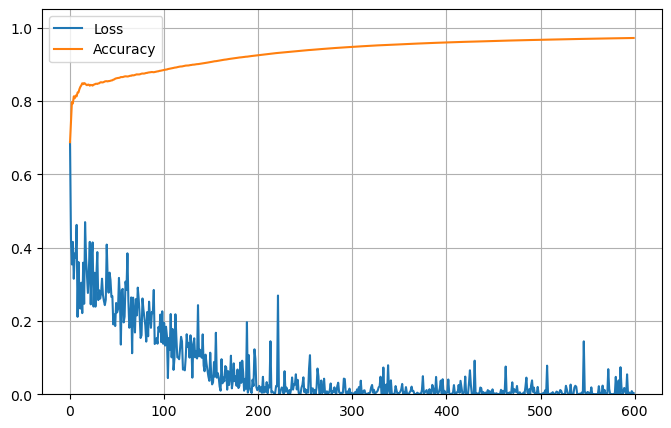

./[plot] CNN_LSTM_layer2.pdf


In [40]:
f = plt.figure(figsize=[8, 5])
f.set_facecolor("white")

plt.style.use(['default'])
plt.plot(loss_arr)
plt.plot(train_acc)


plt.legend(['Loss', 'Accuracy'])
plt.ylim((0.0, 1.05))
plt.grid(True)
plt.show()
print("./"+"[plot] "+model._get_name()+"_"+'layer'+str(num_layers)+".pdf")
f.savefig("./"+"[plot] "+model._get_name()+"_"+'layer'+str(num_layers)+".pdf")


## Model Evaluation

In [42]:
# for confusion matrix

test_pred_acc = []  
test_actual_acc = []  
start = time.time()  # 시작 시간 저장
device = 'cuda:0'
model.to(device)

model.eval()
with torch.no_grad():
    test_acc_tmp, test_precision_tmp, test_recall_tmp, test_f1_tmp = [], [], [], []
    for test_iter, (test_x, test_y_true) in enumerate(testloader):
        test_x, test_y_true = test_x.to(device), test_y_true.to(device)
        test_y_pred = model.forward(test_x)  # forward
        
        _, test_pred_index = torch.max(test_y_pred, 1)

        test_pred_index_cpu = test_pred_index.cpu().detach().numpy()
        test_y_true_cpu = test_y_true.cpu().detach().numpy()
        
        test_pred_acc.append(test_pred_index_cpu)
        test_actual_acc.append(test_y_true_cpu)
            
        test_acc, test_precision, test_recall, test_f1 = get_clf_eval(test_y_true_cpu, test_pred_index_cpu)

        test_acc_tmp.append(test_acc), test_precision_tmp.append(test_precision), test_recall_tmp.append(test_recall), test_f1_tmp.append(test_f1)
    test_acc_mean = sum(test_acc_tmp, 0.0)/len(test_acc_tmp)
    test_precision_mean = sum(test_precision_tmp, 0.0)/len(test_precision_tmp)
    test_recall_mean = sum(test_recall_tmp, 0.0)/len(test_recall_tmp)
    test_f1_mean = sum(test_f1_tmp, 0.0)/len(test_f1_tmp)
    print("[Test] Accuracy : {:.4f}, Precision : {:.4f}, Recall : {:.4f}, F1 Score : {:.4f}".format(
         test_acc_mean, test_precision_mean, test_recall_mean, test_f1_mean))
    print("[Test] Model Performance : {:.5f}".format(test_acc_mean))
print("Time : ", time.time()-start,'[s]',sep='')

[Test] Accuracy : 0.8424, Precision : 0.8468, Recall : 0.8424, F1 Score : 0.8422
[Test] Model Performance : 0.84243
Time : 0.1676795482635498[s]


## Save Model

In [43]:
epoch_str = str(epoch)
lr_str = str(lr)
batch_str= str(batch_size)
acc_str= str(int(test_acc_mean*100))

model_name = "["+model._get_name()+"]"+"(epoch-"+epoch_str+")-"+"(init_lr-"+lr_str+")-"+"(batch-"+batch_str+")-"+"(acc-"+acc_str+").pt"
save_path = os.path.join(path, dir_ , model_name)
print(save_path)

C:\Users\Yoon\Documents\JupyterNotebook_Server\UWB\model\[CNN_LSTM](epoch-100)-(init_lr-0.001)-(batch-64)-(acc-84).pt


In [44]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1d_layer.0.weight 	 torch.Size([10, 1, 4])
conv1d_layer.0.bias 	 torch.Size([10])
conv1d_layer.2.weight 	 torch.Size([20, 10, 5])
conv1d_layer.2.bias 	 torch.Size([20])
lstm.weight_ih_l0 	 torch.Size([128, 504])
lstm.weight_hh_l0 	 torch.Size([128, 32])
lstm.weight_ih_l0_reverse 	 torch.Size([128, 504])
lstm.weight_hh_l0_reverse 	 torch.Size([128, 32])
lstm.weight_ih_l1 	 torch.Size([128, 64])
lstm.weight_hh_l1 	 torch.Size([128, 32])
lstm.weight_ih_l1_reverse 	 torch.Size([128, 64])
lstm.weight_hh_l1_reverse 	 torch.Size([128, 32])
bn.weight 	 torch.Size([64])
bn.bias 	 torch.Size([64])
bn.running_mean 	 torch.Size([64])
bn.running_var 	 torch.Size([64])
bn.num_batches_tracked 	 torch.Size([])
fc_layer.weight 	 torch.Size([128, 64])
fc_layer.bias 	 torch.Size([128])
fc_layer_class.weight 	 torch.Size([2, 128])
fc_layer_class.bias 	 torch.Size([2])


In [46]:
torch.save({'epoch' : epoch,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'loss' : loss
           }, save_path)